## Introduction

### Quick Primer on the Representation Theory of S~n~

The irreducible representations (irreps) of $S_{n}$, the symmetric group on $n$ elements, correspond to partitions of $n$. Since $S_n$ is not abelian for $n \gt 2$, each irrep $\rho$ corresponds to matrices with differing dimensions. The trivial and alternating representations are the only two one-dimensional representations. The _trivial representation_ corresponds to the partition $(1+1+\ldots+1)$ and assigns every permutation to $1$. The _alternating representation_ corresponds to the partition $(n)$ and sends even permutations to $1$ and odd permutations to $-1$. Every matrix representation of $S_{n}$ is a direct sum or tensor product of the irreducible representations.

Given a function $f: S_{n}\rightarrow\mathbb{R}$, the Fourier transform of $f$ maps an irrep of $S_{n}$ to a matrix with the dimension of the irrep, defined as such:
$$ \hat{f}(\rho) = \sum_{\sigma \in S_{n}} f(\sigma)\rho(\sigma) $$

Because $\hat{f}(\rho)$ has a different dimension for every $\rho$, it is harder to visualize than the Fourier transforms over abelian groups. It is worth taking a moment to look at concretely what the transform looks like.

Consider $S_{5}$. The transform corresponding to the trivial representation is given by $$\hat{f}(\rho_{triv}) = \sum_{\sigma \in S_{5}} f(\sigma)$$ which is just the unnormalized sum of all of the values of $f$.

The transform corresponding to the alternating representation $$\hat{f}(\rho_{alt}) =  \sum_{\sigma \in A_{5}} f(\sigma) - \sum_{\sigma \in S_{5} \setminus A_{5}} f(\sigma)$$ is the difference between the values $f$ takes on even versus odd permutations.

For the other irreps $\hat{f}(\rho)$ is matrix valued and is more difficult to interpret, but we still have a tool to understand $f$ more clearly. As with the traditional Fourier transform we can apply the transform again to recover $f$ from $\hat{f}$ with the following formula:
$$ f(\sigma) = \frac{1}{|S_{n}|}\sum_{\rho \in \mathcal{R}} d_{\rho}\operatorname{tr}[\hat{f}(\rho)\rho(\sigma^{-1})]$$ where the sum over $\mathcal{R}$ is over all of the partitions of $n$ and $d_{\rho}$ represents the dimension of the irrep.

What we will do is use this fact to consider the set of partitions as a basis for $f(\sigma)$, and in particular examine the the following vector for a function over $S_{5}$: 
$$ \frac{1}{120} \begin{pmatrix} \hat{f}(\rho_{triv}) \\ sgn(\sigma)\hat{f}(\rho_{alt}) \\ 4 \cdot \operatorname{tr}[\hat{f}(\rho_{(4, 1)})\rho_{(4, 1)}(\sigma^{-1})] \\ 5 \cdot \operatorname{tr}[\hat{f}(\rho_{(3, 2)})\rho_{(3, 2)}(\sigma^{-1})] \\ 6 \cdot \operatorname{tr}[\hat{f}(\rho_{(3, 1, 1)})\rho_{(3, 1, 1)}(\sigma^{-1})] \\ 5 \cdot \operatorname{tr}[\hat{f}(\rho_{(2, 2, 1)})\rho_{(2, 2, 1)}(\sigma^{-1})] \\ 4 \cdot \operatorname{tr}[\hat{f}(\rho_{(2, 1, 1, 1)})\rho_{(2, 1, 1, 1)}(\sigma^{-1})] \end{pmatrix}$$

This may not seem to achieve much--we have taken a scalar function and produced a seemingly more complicated vector function. But in practice for many functions only one or two irreps contribute to $f$ and the above vector is sparse. In particular my preliminary investigations show that the activations of an over-parametrized MLP that perfectly learns $S_{5}$ are sparse in the above Fourier basis.


In [3]:
### Set up
import math
import numpy as np
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle
)
import polars as pl
import torch
import functorch



from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d
from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep



In [4]:

def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')



def make_embed_barplot_2d(data, lperm, rperm, irreps, title_prefix):
    df = data.filter(
          (pl.col('permutation_left') == str(lperm.sigma)) 
        & (pl.col('permutation_right') == str(rperm.sigma))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1]))
    ).rename(
        {col: col[3:] for col in linear_df.columns if col.startswith('dim')}
    ).melt(
        id_vars=['permutation_left', 'permutation_right','irrep_left', 'irrep_right']
    ).with_columns(
        [pl.col('variable').str.parse_int(radix=10),
        (pl.col('irrep_left') + '|' + pl.col('irrep_right')).alias('irrep')]
    ).filter(
        pl.col('irrep').is_in(irreps)
    ).to_pandas()
    return (
        ggplot(df, aes(x='reorder(factor(variable), np.abs(value))', y='value', fill='irrep')) 
        + geom_col()
        #+ facet_wrap('~variable_group') 
        + xlab('Linear Dimension')
        + ylab('Value')
        + ggtitle(f'{title_prefix}: {str(lperm.sigma)}  v. {rperm.sigma}')
        + theme(axis_text_x=element_text(rotation=60, hjust=1))
    )


def make_embed_scatterplot(data, mindim, maxdim):
    filtered_df = data.filter(
        pl.col('conjugacy_class') != '(1, 1, 1, 1, 1)'
    ).filter(pl.col('embed_dim') < maxdim).filter(pl.col('embed_dim') >= mindim)

    return (ggplot(
        filtered_df.to_pandas(),
        aes(x='(5,)', y='(2, 1, 1, 1)', fill='parity')) 
     + geom_point() 
     + facet_wrap('~embed_dim', nrow=4)
     + xlab('Sign Representation')
     + ylab('Standard X Sign Representation')
     + ggtitle(f'S5 Left Embedding Dims {mindim}-{maxdim - 1}')
    )


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data



In [5]:
### Load Model

run = torch.load('checkpoints/s5_50_02/full_run.pth', map_location=torch.device('cpu'))
model = SnMLP.from_config(run['config'])
model.load_state_dict(run['model'])



<All keys matched successfully>

## Embeddings

### Power Spectrum

The model has learned two 256 dimensional representations for each for permutation, one for when that permutation appears on the left and one for the right. We apply the above framework by treating each embedding as a function $S_{5} \rightarrow \mathbb{R}^{256}$ and applying the Fourier transform elementwise across the embedding dimension.

We can see that across dimensions 


In [9]:
fourier_lembed = slow_ft_1d(model.lembed.weight.to(torch.float64), 5)
fourier_rembed = slow_ft_1d(model.rembed.weight.to(torch.float64), 5)

ft_decomp_lembed = sn_fourier_basis(fourier_lembed, 5)
ft_decomp_rembed = sn_fourier_basis(fourier_rembed, 5)

In [10]:
from sngrok.fourier import calc_power

power_lembed = calc_power(fourier_lembed, 120)

In [17]:
power_lembed[(3, 2)][0]

tensor(0.0076, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [33]:




power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))


irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(1, 1, 1, 1, 1...",0.000046,0.000099,0.000015,0.000047,0.000032,0.000019,0.000002,0.000003,0.000095,0.000003,2.5411e-8,1.6232e-7,0.00007,0.000042,0.000097,0.000088,0.000002,0.000024,0.000023,0.000002,0.000071,0.000001,0.000294,0.000024,0.000178,0.00013,0.000015,0.00007,0.000407,0.000009,0.000104,6.3735e-7,0.000127,0.000227,0.000035,0.000211,...,0.000164,0.000011,0.000003,0.00001,0.000015,8.4680e-7,0.000007,0.000031,0.000024,0.000004,0.000033,0.000011,0.000001,3.6381e-8,0.00001,0.000001,0.00001,0.000003,0.000004,0.0001,0.000017,0.000012,0.000105,0.000003,0.000069,0.000029,0.000001,0.000073,0.000009,0.000003,0.000073,0.000154,0.000089,5.1512e-9,0.000006,0.000066,0.000153
"""(2, 1, 1, 1)""",0.675678,0.724933,0.695858,0.690677,0.704629,0.661537,0.736582,0.711023,0.705652,0.729387,0.711931,0.69801,0.760167,0.703564,0.786631,0.648364,0.667896,0.724582,0.695396,0.705606,0.695161,0.767054,0.743521,0.6783,0.688975,0.687225,0.669359,0.736762,0.688411,0.711185,0.673649,0.733194,0.716211,0.631553,0.730782,0.710005,...,0.75694,0.673177,0.716001,0.72964,0.68207,0.698266,0.660595,0.760719,0.738464,0.69224,0.719544,0.703416,0.668658,0.731027,0.725379,0.709873,0.734869,0.707375,0.73114,0.70468,0.701455,0.735725,0.706958,0.682519,0.629804,0.679398,0.748716,0.68072,0.692222,0.774579,0.682863,0.690459,0.687915,0.7556,0.749997,0.793774,0.751264
"""(2, 2, 1)""",0.03058,0.037389,0.014814,0.046671,0.040058,0.048579,0.032511,0.01666,0.056324,0.045886,0.037353,0.050777,0.049803,0.044192,0.041545,0.036159,0.073048,0.041804,0.038774,0.032285,0.057398,0.059959,0.036359,0.033412,0.038436,0.042627,0.04126,0.030796,0.024395,0.036324,0.047792,0.028013,0.033244,0.065071,0.044175,0.052924,...,0.03387,0.045869,0.047499,0.041335,0.032175,0.07111,0.054849,0.054159,0.026552,0.050258,0.055173,0.041586,0.034071,0.03749,0.038819,0.04403,0.036829,0.054429,0.036824,0.035848,0.029824,0.027377,0.037252,0.072492,0.047848,0.024103,0.041344,0.032462,0.045061,0.041228,0.062993,0.034685,0.04477,0.020371,0.031216,0.031286,0.036576
"""(3, 1, 1)""",0.00178,0.001817,0.001847,0.002212,0.004626,0.001628,0.001519,0.001315,0.002488,0.002685,0.0027,0.004896,0.004376,0.002105,0.00431,0.002671,0.004072,0.003309,0.001897,0.002257,0.002986,0.003309,0.001337,0.001685,0.003376,0.002168,0.003169,0.002716,0.002048,0.001318,0.0019,0.002164,0.002156,0.002766,0.002215,0.003528,...,0.001485,0.003158,0.001812,0.002939,0.002218,0.002432,0.004419,0.00309,0.001655,0.002066,0.002954,0.003774,0.00296,0.001418,0.002476,0.002117,0.00226,0.001908,0.002476,0.002897,0.001354,0.002851,0.001883,0.006171,0.003767,0.003573,0.002429,0.002021,0.00275,0.003377,0.002145,0.003017,0.003235,0.002742,0.00172,0.001588,0.0025
"""(3, 2)""",0.205713,0.156169,0.201507,0.172569,0.15397,0.210685,0.147528,0.196586,0.153487,0.141559,0.180425,0.148684,0.08832,0.176209,0.066068,0.20112,0.150206,0.145743,0.186058,0.19488,0.163121,0.114406,0.160742,0.168041,0.165151,0.184567,0.181094,0.159689,0.20008,0.167835,0.179718,0.151073,0.18217,0.20291,0.165817,0.150962,...,0.149783,0.187624,0.135668,0.164124,0.178504,0.135741,0.157427,0.09937,0.156623,0.167464,0.132191,0.146172,0.194174,0.15275,0.155534,0.173844,0.140955,0.149466,0.148212,0.161624,0.176166,0.142885,0.183668,0.15

In [34]:
val_data.melt(id_vars='irrep').head()

irrep,variable,value
str,str,f64
"""(1, 1, 1, 1, 1...","""dim0""",0.000046
"""(2, 1, 1, 1)""","""dim0""",0.675678
"""(2, 2, 1)""","""dim0""",0.03058
"""(3, 1, 1)""","""dim0""",0.00178
"""(3, 2)""","""dim0""",0.205713


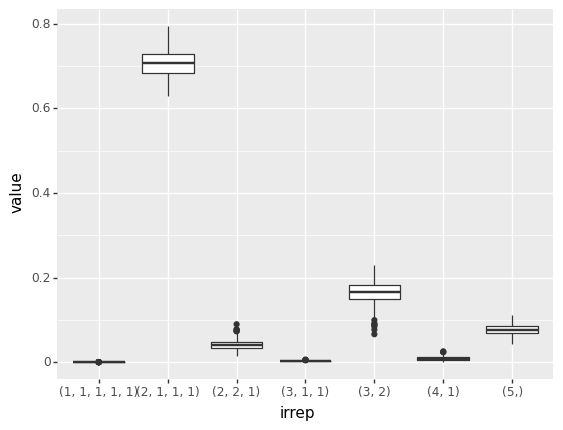

<ggplot: (393844866)>

In [38]:
from plotnine import geom_boxplot 
ggplot(val_data.melt(id_vars='irrep'), aes(x='irrep', y='value')) + geom_boxplot()

In [40]:


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


rval_data = calc_power_contributions(model.rembed.weight.to(torch.float64), 5)

ggplot(rval_data.melt(id_vars='irrep'), aes(x='irrep', y='value')) + geom_boxplot()

NameError: name 'frob' is not defined